In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict,Counter
from random import sample

In [2]:
class NeuralNet:
    def __init__(self,nodes,lamb=0.0,alpha=0.1,eps=0.0):
        '''
        Constructor for neural net
        nodes - list detailing number of nodes in each layer
        lamb - regularization
        alpha - learning rate
        eps - cost function stopping condition
        '''
        self.nodes = nodes
        self.lamb = lamb
        self.alpha = alpha
        self.weights = []
        self.eps = eps
        #initialize weights for each layer, include bias
        for i in range(len(nodes)-1):
            self.weights.append(np.random.normal(0,1,(nodes[i]+1,nodes[i+1])).T)
    
    def get_sigmoid(self, x):
        return 1 / (1+np.exp(-x))
    
    def deriv_sigmoid(self, x):
        return x * (1-x)

    def train(self, features, targs, batch_size, test_feat=None, test_targs=None, for_exam=False, get_costs=False):
        '''
        features - training data features
        targs - training data targets
        batch size - # of instances for mini batch
        test_feat - test data features
        test_targs - test data targets
        for_exam - flag to print for back_prop examples
        get_costs - flag to get J values for varying number of samples
        '''
        prev_cost = math.inf
        gradients = [0]*len(self.weights)
        num_inst = len(targs)
        keep_learn = True
        count = 1
        curr_batch = 1
        cost_j = []
        cost_j_count = []

        while(keep_learn):
            J = 0
            for instance,target in zip(features,targs):
                #iterate through layers, vectorize forward pass
                activations = [np.atleast_2d(instance)]
                for i in range(len(self.weights)-1):
                    try:
                        this_a = self.get_sigmoid(self.weights[i].dot(activations[i].T))
                    except:
                        this_a = self.get_sigmoid(self.weights[i].T.dot(activations[i].T))
                    activations.append(np.insert(this_a,0,1))
                try:
                    activations.append(self.get_sigmoid(activations[len(self.weights)-1].dot(self.weights[len(self.weights)-1])))
                except:
                    activations.append(self.get_sigmoid(activations[len(self.weights)-1].dot(self.weights[len(self.weights)-1].T)))
                guess = activations[-1]

                #accumulate sum loss
                target = np.array(target)
                cost = np.sum((np.array(-target)).dot(np.log(guess)) - (np.array(1-target)).dot(np.log(1-guess)))
                J += cost

                #begin backwards propogation
                error = guess - target
                delta_inst = [error]

                #get delta values for all weights on current instance
                for i in range(len(self.weights)-1, 0, -1):
                    try:
                        this_del = (self.weights[i].T.dot(delta_inst[-1])) * self.deriv_sigmoid(activations[i].T)
                    except:
                        this_del = (self.weights[i].dot(delta_inst[-1])) * self.deriv_sigmoid(activations[i].T)
                    delta_inst.append(this_del[1:])

                #reverse delta values
                delta_inst = delta_inst[::-1]

                #accumulate gradients
                for i in range(len(self.weights)-1,-1,-1):
                    try:
                        gradients[i] += (delta_inst[i]*(activations[i].T)).T
                    except:
                        gradients[i] += (np.atleast_2d(delta_inst[i]).T*np.atleast_2d(activations[i].T))

                #print for examples
                if for_exam:
                    print(f'OUTPUTS FOR INSTANCE {count}')
                    print(f'activations: ')
                    for i in range(len(activations)):
                        print(f'a{i+1}: {activations[i]}')
                    print()
                    print(f'prediction: {guess}')
                    print(f'expected: {target}')
                    print(f'cost J: {cost}')
                    print()
                    print('delta for this instance: ')
                    for i in range(len(delta_inst)):
                        print(f'delta {i+2}: {delta_inst[i]}')
                    print()
                    print('gradients for this instance: ')
                    for i in range(len(self.weights)):
                        try:
                            print_del = (delta_inst[i]*(activations[i].T)).T
                        except:
                            print_del = (np.atleast_2d(delta_inst[i]).T*np.atleast_2d(activations[i].T)).T
                        print(f'theta {i+1}: {print_del}')
                    print()

                if curr_batch == batch_size:
                    #regularize weights and update
                    for i in range(len(self.weights)-1,-1,-1):
                        P = self.lamb * (self.weights[i])
                        #set first column to all 0
                        P[:,0] = 0
                        try:
                            gradients[i] = gradients[i] + P.T
                        except:
                            gradients[i] = gradients[i] + P
                        gradients[i] = gradients[i] / num_inst
                        learn_diff = self.alpha * (gradients[i])
                        try:
                            self.weights[i] = self.weights[i] - learn_diff
                        except:
                            self.weights[i] = self.weights[i] - learn_diff.T
                    curr_batch = 0

                    if get_costs:
                        cost_j.append(self.cost_on_set(test_feat,test_targs))
                        cost_j_count.append(count)

                curr_batch += 1
                count += 1

            J /= num_inst
            curr_s = 0
            for i in range(len(self.weights)):
                curr_s += np.sum(self.weights[i][1:]**2)

            #curr_s = np.sum(self.weights[1:]**2)
            curr_s *= (self.lamb/(2*num_inst))
            new_cost = J + curr_s

            #if improvement in cost is less than epsilon, stop
            if prev_cost - new_cost < self.eps:
                keep_learn = False

            prev_cost = new_cost

            if for_exam:
                print('regularized gradients: ')
                for i in range(len(gradients)):
                    print(f'theta {i+1}: {gradients[i]}')
                keep_learn = False
            if get_costs:
                return cost_j,cost_j_count

    #forward pass on one instance, returns an array where index of max val is the NN's guess and 0 for all else
    #for example a guess for class 0 of 3 possible classes 0,1,2 would be [1,0,0]
    #raw - True if wanting the raw outputs, false if wanting fixed as discussed above
    def predict(self,instance,raw=True):
        activations = [np.atleast_2d(instance)]
        for i in range(len(self.weights)-1):
            try:
                this_a = self.get_sigmoid(self.weights[i].dot(activations[i].T))
            except:
                this_a = self.get_sigmoid(self.weights[i].T.dot(activations[i].T))
            activations.append(np.insert(this_a,0,1))
        try:
            activations.append(self.get_sigmoid(activations[len(self.weights)-1].dot(self.weights[len(self.weights)-1])))
        except:
            activations.append(self.get_sigmoid(activations[len(self.weights)-1].dot(self.weights[len(self.weights)-1].T)))
        guess = activations[-1]
        pred = [0]*len(guess)
        pred[np.argmax(guess)] = 1
        
        return guess if raw else pred
    
    def cost_on_set(self,instances,targets):
        J = 0
        for instance,target in zip(instances,targets):
            guess = self.predict(instance)
            target = np.array(target)
            cost = np.sum((np.array(-target)).dot(np.log(guess)) - (np.array(1-target)).dot(np.log(1-guess)))
            J += cost
        J /= len(instances)
        curr_s = 0
        for i in range(len(self.weights)):
            curr_s += np.sum(self.weights[i][1:]**2)

        curr_s *= (self.lamb/(2*len(instances)))
        return J + curr_s

In [137]:
def test_decision(nn,test_set,vals):
    test_copy = pd.DataFrame(test_set,copy=True)
    #test_copy.insert(0,'bias',1)
    to_guess = test_copy.drop('class',axis=1)
    predictions = pd.DataFrame(to_guess.apply(lambda row: nn.predict(row.to_numpy(),raw=False), axis=1),columns=['predicted'])
    predictions['actual'] = test_set.loc[predictions.index,'class']
    prec,rec,f1 = [0,0,0]

    for val in vals:
        is_targ = predictions[predictions.predicted.apply(lambda x: x == val)]
        not_targ = predictions[predictions.predicted.apply(lambda x: x != val)]
        tp = len(is_targ[is_targ['predicted'] == is_targ['actual']])
        fp = len(is_targ[is_targ['predicted'] != is_targ['actual']])
        fn = len(not_targ[not_targ.actual.apply(lambda x: x == val)])
        tn = len(not_targ[not_targ.actual.apply(lambda x: x != val)])
        this_prec = (tp/(tp+fp)) if (tp+fp) > 0 else 0
        this_rec = (tp/(tp+fn)) if (tp+fn) > 0 else 0
        f1 += (this_prec*this_rec*2)/(this_rec+this_prec) if (this_rec+this_prec) > 0 else 0
        prec += this_prec
        rec += this_rec

    avg_f1 = f1/len(vals)
    accuracy = len(predictions[predictions['predicted'] == predictions['actual']])/len(test_set)
    return accuracy,avg_f1

np.random.seed(1)
k = 10
#function to do cross fold validation
def k_fold(fold,vals,nn_arc,lamb,eps,alpha,batch_size,get_j=False):
    fold_metrics = defaultdict(list)
    #iterate through folds, taking turns being test fold
    for i in range(k):
        test_fold = fold[i]
        #test_fold.insert(0,'bias',1)
        test_targs = test_fold['class']
        test_feat = test_fold.drop('class',axis=1)
        train_fold = fold[0:i]
        train_fold.extend(fold[i+1:len(fold)])
        train_data = pd.concat(train_fold)
       
        #train_data.insert(0,'bias',1)
        #iterate through architectures
        for arc in nn_arc:
            np_targs = train_data['class'].to_numpy()
            np_inst = train_data.drop('class',axis=1).to_numpy()
            this_nn = NeuralNet(arc,lamb,alpha,eps)
            if get_j:
                return this_nn.train(np_inst,np_targs,batch_size,test_feat.to_numpy(),test_targs.to_numpy(),get_costs=True)
            this_nn.train(np_inst,np_targs,batch_size)
            fold_metrics[str(arc)].append(test_decision(this_nn,test_fold,vals))
            
    return fold_metrics

## 1. Wine Dataset

In [208]:
#list of neural net architectures
wine_nn_arc = [[13,4,3],[13,8,3],[13,4,8,3],[13,8,16,3],[13,2,4,8,3],[13,2,4,8,4,3]]
wine_df = pd.read_csv('datasets/hw3_wine.csv',delimiter='\t')
norm_wine_df = ((wine_df-wine_df.min())/(wine_df.max()-wine_df.min()))
#insert column of ones to act as bias
norm_wine_df.insert(0,'bias',1)

#split data by class into k groups then combine into folds
wine_class_1 = norm_wine_df.loc[norm_wine_df['class'] == 0].sample(frac=1)
wine_class_1['class'] = [[1,0,0]]*len(wine_class_1)
wc1_split = np.array_split(wine_class_1,k)
wine_class_2 = norm_wine_df.loc[norm_wine_df['class'] == 0.5].sample(frac=1)
wine_class_2['class'] = [[0,1,0]]*len(wine_class_2)
wc2_split = np.array_split(wine_class_2,k)
wine_class_3 = norm_wine_df.loc[norm_wine_df['class'] == 1].sample(frac=1)
wine_class_3['class'] = [[0,0,1]]*len(wine_class_3)
wc3_split = np.array_split(wine_class_3,k)
wine_vals = [[1,0,0],[0,1,0],[0,0,1]]

#list to hold folds
wine_fold = []
for i in range(k):
    this_fold = [wc1_split[i],wc2_split[i],wc3_split[i]]
    wine_fold.append(pd.concat(this_fold))  

**1.3**  create, for each dataset and for each of the metrics
described above, a table summarizing the corresponding results

In [209]:
wine_res = k_fold(wine_fold,wine_vals,wine_nn_arc,0.1,0.001,1,5)

arc_dict = defaultdict(list)

for arc,perf in wine_res.items():
    avg_acc,avg_f1 = [0,0]
    for res in perf:
        avg_acc += res[0]
        avg_f1 += res[1]
    arc_dict['Architecture'].append(arc)
    arc_dict['Accuracy'].append(avg_acc/10)
    arc_dict['F1'].append(avg_f1/10)

arc_table = pd.DataFrame(arc_dict)
print(arc_table)

          Architecture  Accuracy        F1
0           [13, 4, 3]  0.977743  0.977975
1           [13, 8, 3]  0.973099  0.974010
2        [13, 4, 8, 3]  0.443698  0.251319
3       [13, 8, 16, 3]  0.793658  0.744764
4     [13, 2, 4, 8, 3]  0.399254  0.190154
5  [13, 2, 4, 8, 4, 3]  0.399254  0.190154


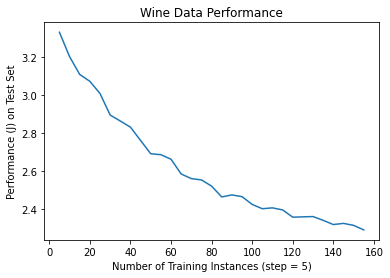

In [207]:
wine_j,wine_count = k_fold(wine_fold,wine_vals,[[13,8,3]],0.1,0.001,1,5,get_j=True)
plt.plot(wine_count,wine_j)
plt.xlabel('Number of Training Instances (step = 5)')
plt.ylabel('Performance (J) on Test Set')
plt.title('Wine Data Performance')
plt.show()

In [3]:
#list of neural net architectures
house_nn_arc = [[13,4,3],[13,8,3],[13,4,8,3],[13,8,16,3],[13,2,4,8,3],[13,2,4,8,4,3]]
house_df = pd.read_csv('datasets/hw3_house_votes_84.csv',delimiter='\t')
norm_house_df = ((house_df-house_df.min())/(house_df.max()-house_df.min()))
#insert column of ones to act as bias
norm_house_df.insert(0,'bias',1)

#split data by class into k groups then combine into folds
house_class_1 = norm_house_df.loc[norm_house_df['class'] == 0].sample(frac=1)
house_class_1['class'] = [[1,0,0]]*len(house_class_1)
hc1_split = np.array_split(house_class_1,k)
house_class_2 = norm_house_df.loc[norm_house_df['class'] == 0.5].sample(frac=1)
house_class_2['class'] = [[0,1,0]]*len(house_class_2)
hc2_split = np.array_split(house_class_2,k)
house_class_3 = norm_house_df.loc[norm_house_df['class'] == 1].sample(frac=1)
house_class_3['class'] = [[0,0,1]]*len(house_class_3)
hc3_split = np.array_split(house_class_3,k)
house_vals = [[1,0,0],[0,1,0],[0,0,1]]

#list to hold folds
house_fold = []
for i in range(k):
    this_fold = [hc1_split[i],hc2_split[i],hc3_split[i]]
    house_fold.append(pd.concat(this_fold))  

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
house_res = k_fold(wine_fold,wine_vals,wine_nn_arc,0.1,0.001,1,5)

arc_dict_h = defaultdict(list)

for arc,perf in house_res.items():
    avg_acc,avg_f1 = [0,0]
    for res in perf:
        avg_acc += res[0]
        avg_f1 += res[1]
    arc_dict['Architecture'].append(arc)
    arc_dict['Accuracy'].append(avg_acc/10)
    arc_dict['F1'].append(avg_f1/10)

arc_table_h = pd.DataFrame(arc_dict_h)
print(arc_table_h)

In [ ]:
wine_j,wine_count = k_fold(wine_fold,wine_vals,[[13,8,3]],0.1,0.001,1,5,get_j=True)
plt.plot(wine_count,wine_j)
plt.xlabel('Number of Training Instances (step = 5)')
plt.ylabel('Performance (J) on Test Set')
plt.title('Wine Data Performance')
plt.show()

**2.1 Correctness Verification**

Below I have included 2 functions: ```train_on_first()``` and ```train_on_sec()```

These functions hard code the inputs and print the desired outputs to stdout. If the output is too large for your IDE, set the max lines of your output to 100. To run these functions, simply call them without arguement.

In [156]:
#function to train on backprop_example1.txt
#outputs to stdout, if full output cannot be viewed when calling this function, increase number of lines shown in output to 100
def train_on_first():
	train_nn = NeuralNet([1,2,1],eps=0.001)
	train_nn.weights[0] = np.array([[0.40000,0.10000 ],[0.30000,0.20000 ]])
	train_nn.weights[1] = np.array([[0.7],[0.5],[0.6]])
	train_set_1 = {'x': [0.13000,0.42000], 'y': [0.90000,0.23000]}
	#NOTE: X values are preprocessed to include bias term (1) as first element
	X = np.array([[1,0.13000],[1,0.42000]])
	Y = np.array([[0.90000],[0.23000]])
	train_df = pd.DataFrame(data=train_set_1)
	train_df.insert(0,'bias',np.ones)
	train_nn.train(X,Y,2,for_exam=True)

train_on_first()

OUTPUTS FOR INSTANCE 1
activations: 
a1: [[1.   0.13]]
a2: [1.        0.601807  0.5807858]
a3: [0.79402743]

prediction: [0.79402743]
expected: [0.9]
cost J: 0.36557477431084995

delta for this instance: 
delta 2: [-0.01269739 -0.01548092]
delta 3: [-0.10597257]

gradients for this instance: 
theta 1: [[-0.01269739 -0.00165066]
 [-0.01548092 -0.00201252]]
theta 2: [-0.10597257 -0.06377504 -0.06154737]

OUTPUTS FOR INSTANCE 2
activations: 
a1: [[1.   0.42]]
a2: [1.         0.60873549 0.59483749]
a3: [0.79596607]

prediction: [0.79596607]
expected: [0.23]
cost J: 1.2763768066887786

delta for this instance: 
delta 2: [0.06739994 0.08184068]
delta 3: [0.56596607]

gradients for this instance: 
theta 1: [[0.06739994 0.02830797]
 [0.08184068 0.03437309]]
theta 2: [0.56596607 0.34452363 0.33665784]

regularized gradients: 
theta 1: [[0.02735127 0.01332866]
 [0.03317988 0.01618028]]
theta 2: [[0.22999675 0.1403743  0.13755523]]


In [158]:
#function to train on backprop_example2.txt
#outputs to stdout, if full output cannot be viewed when calling this function, increase number of lines shown in output to 100
def train_on_sec():
	train_nn = NeuralNet([2,4,3,2],eps=0.001,lamb=0.250)
	train_nn.weights[0] = np.array([[0.42000,0.15000,0.40000],[0.72000,0.10000,0.54000],[0.01000,0.19000,0.42000],[0.30000,0.35000,0.68000]])
	train_nn.weights[1] = np.array([[0.21000,0.67000,0.14000,0.96000,0.87000],[0.87000,0.42000,0.20000,0.32000,0.89000],[0.03000,0.56000,0.80000,0.69000,0.09000]])
	train_nn.weights[2] = np.array([[0.04000,0.87000,0.42000,0.53000],[0.17000,0.10000,0.95000,0.69000]])
	train_set_1 = {'x': [0.13000,0.42000], 'y': [0.90000,0.23000]}
	#NOTE: X values are preprocessed to include bias term (1) as first element
	X = np.array([[1,0.32000,0.68000],[1,0.83000,0.02000]])
	Y = np.array([[0.75000,0.98000],[0.75000,0.28000]])
	train_nn.train(X,Y,batch_size=2,for_exam=True)

#train_on_first()
train_on_sec()

OUTPUTS FOR INSTANCE 1
activations: 
a1: [[1.   0.32 0.68]]
a2: [1.         0.67699586 0.75384029 0.5881687  0.70566042]
a3: [1.         0.87519469 0.89296181 0.81480444]
a4: [0.83317658 0.84131543]

prediction: [0.83317658 0.84131543]
expected: [0.75 0.98]
cost J: 0.7907366961135718

delta for this instance: 
delta 2: [-0.00086743 -0.00133354 -0.00053312 -0.00070163]
delta 3: [ 0.00638937 -0.00925379 -0.00778767]
delta 4: [ 0.08317658 -0.13868457]

gradients for this instance: 
theta 1: [[-0.00086743 -0.00027758 -0.00058985]
 [-0.00133354 -0.00042673 -0.00090681]
 [-0.00053312 -0.0001706  -0.00036252]
 [-0.00070163 -0.00022452 -0.00047711]]
theta 2: [[ 0.00638937 -0.00925379 -0.00778767]
 [ 0.00432557 -0.00626478 -0.00527222]
 [ 0.00481656 -0.00697588 -0.00587066]
 [ 0.00375802 -0.00544279 -0.00458046]
 [ 0.00450872 -0.00653003 -0.00549545]]
theta 3: [[ 0.08317658 -0.13868457]
 [ 0.0727957  -0.121376  ]
 [ 0.07427351 -0.12384003]
 [ 0.06777264 -0.1130008 ]]

OUTPUTS FOR INSTANCE 2
act